In [1]:
import datetime

import tensorflow as tf
from sklearn.model_selection import train_test_split
from src.dataset import SegmentationDataset
from src.data_pipeline import SegmentationDataPipeline
from keras import backend as K
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import numpy as np

from src.train2 import train_model
from src.data_utils import plot_sample_batch
from src.model_utils import (
    tversky,
    tversky_loss,
    tversky_axis,
    # tversky_loss_axis,
    TverskyLossAxis,
)


%load_ext lab_black
%load_ext autoreload
%autoreload 2

2022-10-26 02:16:01.547121: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 02:16:02.574836: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/cuda/lib::/usr/lib/hadoop/lib/native
2022-10-26 02:16:02.575021: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/cuda/lib::/usr/lib/hadoop/lib/native
2022-10-26 0

In [2]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2.0 * K.sum(intersection) + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )
    return 1.0 - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [3]:
IMG_SHAPE = (256, 1600)
BATCH_SIZE = 8
TEST_SIZE = 0.1
ANNOTATIONS_PATH = "../data/train.csv"
TRAIN_IMG_PATH = "../data/train_images/"
LOSSES = {
    "tversky_loss": tversky_loss,
    "TverskyLossAxis": TverskyLossAxis(),
    "bce_dice_loss": bce_dice_loss,
}
METRICS = {"tversky": tversky, "tversky_axis": tversky_axis, "dice_coeff": dice_coef}
METRICS = {"dice_coeff": dice_coef}
LOGDIR = f'../logs3/test_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'

In [4]:
kwargs = {
    "n_epochs": 25,
    "learning_rate": 0.001,
    "n_channels_bottleneck": 128,
    "custom_log_dir": LOGDIR,
    "loss_fn": "bce_dice_loss",
    "small_sample": True,
    "img_shape": IMG_SHAPE,
    "batch_size": BATCH_SIZE,
    "test_size": TEST_SIZE,
    "annotations_path": ANNOTATIONS_PATH,
    "train_img_path": TRAIN_IMG_PATH,
    "losses": LOSSES,
    "metrics": METRICS,
    "resample_train_set": False,
    "sample_weights": True,
    "sample_weight_strategy": "ens",
    "sample_weight_ens_beta": 0.9,
}

In [5]:
# instantiate dataset and pipelne
sd = SegmentationDataset(
    test_size=TEST_SIZE,
    label_file=ANNOTATIONS_PATH,
    img_dir_path=TRAIN_IMG_PATH,
    img_shape=IMG_SHAPE,
    sample_weight_strategy="ens",
    sample_weight_ens_beta=0.9,
)

# create train/test & x/y splits
train_imgs = sd.train_imgs
test_imgs = sd.test_imgs

# get stratified sample
_, train_imgs = train_test_split(
    sd.imgid_to_classid_mapping[train_imgs],
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=sd.imgid_to_classid_mapping[train_imgs],
)
_, test_imgs = train_test_split(
    sd.imgid_to_classid_mapping[test_imgs],
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=sd.imgid_to_classid_mapping[test_imgs],
)

{-2: 1.0, -1: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


In [6]:
# get batch with two of each defect type
imgs = []

for class_id in list(range(1, 5)):
    train_imgs[train_imgs == 1]
    imgs.extend(list(train_imgs[train_imgs == class_id][:2].index))

In [8]:
train_imgs = imgs
test_imgs = list(test_imgs.index)[:8]

TypeError: 'builtin_function_or_method' object is not iterable

In [9]:
# train_imgs = list(train_imgs.index)
# test_imgs = list(test_imgs.index)

X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="preprocessed")
X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="preprocessed")

# create dataset pipelines
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="preprocessed",
    pipeline_options={
        "map_parallel": None,  # off if None
        "cache": False,
        "shuffle_buffer_size": False,  # off if False
        "batch_size": BATCH_SIZE,
        "prefetch": False,  # off if False
    },
)

# train_sample_weights = sd.get_sample_weight_sequence(train_imgs)
# train_dataset = sdp(
#     X_train, y_train, is_train=True, sample_weights=train_sample_weights
# )
train_dataset = sdp(X_train, y_train, is_train=True)
test_dataset = sdp(X_test, y_test, is_train=False)

Batching
Batching


2022-10-26 02:16:59.405555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 02:16:59.429566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 02:16:59.430669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 02:16:59.434655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 02:16:59.435755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [10]:
unet, n_epochs, callbacks = train_model(**kwargs)

In [11]:
# unet.summary()

In [12]:
train_dataset = train_dataset.take(1)
test_dataset = test_dataset.take(1)

In [13]:
hist = unet.fit(
    x=train_dataset,
    epochs=600,
    validation_data=test_dataset,
    callbacks=callbacks,
)

Epoch 1/600


2022-10-26 02:17:14.258813: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8202
2022-10-26 02:17:14.947002: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-26 02:17:14.949896: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-26 02:17:14.949973: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-26 02:17:14.951188: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-26 02:17:14.951259: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 10s 10s/step - loss: 1.8476 - dice_coef: 0.0113 - val_loss: 1.6886 - val_dice_coef: 0.0066
Epoch 2/600
1/1 [==============================] - 2s 2s/step - loss: 1.8150 - dice_coef: 0.0113 - val_loss: 1.6881 - val_dice_coef: 0.0066
Epoch 3/600
1/1 [==============================] - 2s 2s/step - loss: 1.7921 - dice_coef: 0.0112 - val_loss: 1.6875 - val_dice_coef: 0.0066
Epoch 4/600
1/1 [==============================] - 2s 2s/step - loss: 1.7751 - dice_coef: 0.0111 - val_loss: 1.6871 - val_dice_coef: 0.0066
Epoch 5/600
1/1 [==============================] - 2s 2s/step - loss: 1.7577 - dice_coef: 0.0112 - val_loss: 1.6869 - val_dice_coef: 0.0066
Epoch 6/600
1/1 [==============================] - 2s 2s/step - loss: 1.7451 - dice_coef: 0.0112 - val_loss: 1.6865 - val_dice_coef: 0.0066
Epoch 7/600
1/1 [==============================] - 2s 2s/step - loss: 1.7313 - dice_coef: 0.0112 - val_loss: 1.6859 - val_dice_coef: 0.0066
Epoch 8/600
1/1 [=============

In [16]:
unet.save("overfit_unet_sigmoid_bce_dice_loss_6822.h5")

In [14]:
sample = list(train_dataset.take(1).as_numpy_iterator())

x = sample[0][0]
y_true = sample[0][1]
y_pred = unet.predict(x)

x.shape, y_true.shape, y_pred.shape

1/1 [==============================] - 0s 468ms/step


((8, 256, 1600, 3), (8, 256, 1600, 4), (8, 256, 1600, 4))

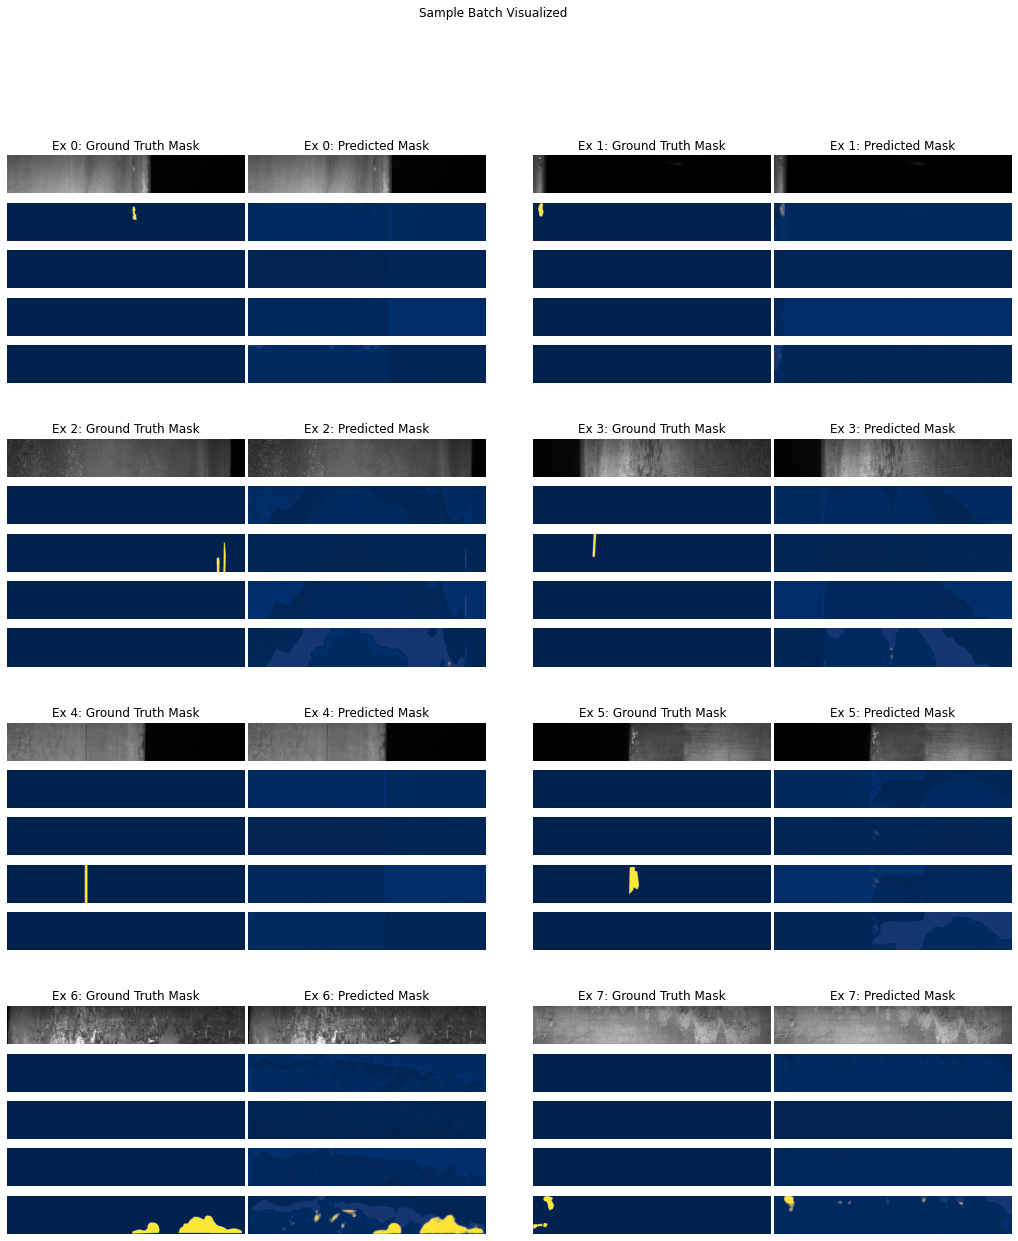

In [15]:
plot_sample_batch(x, y_true, y_pred, softmax_output=False)

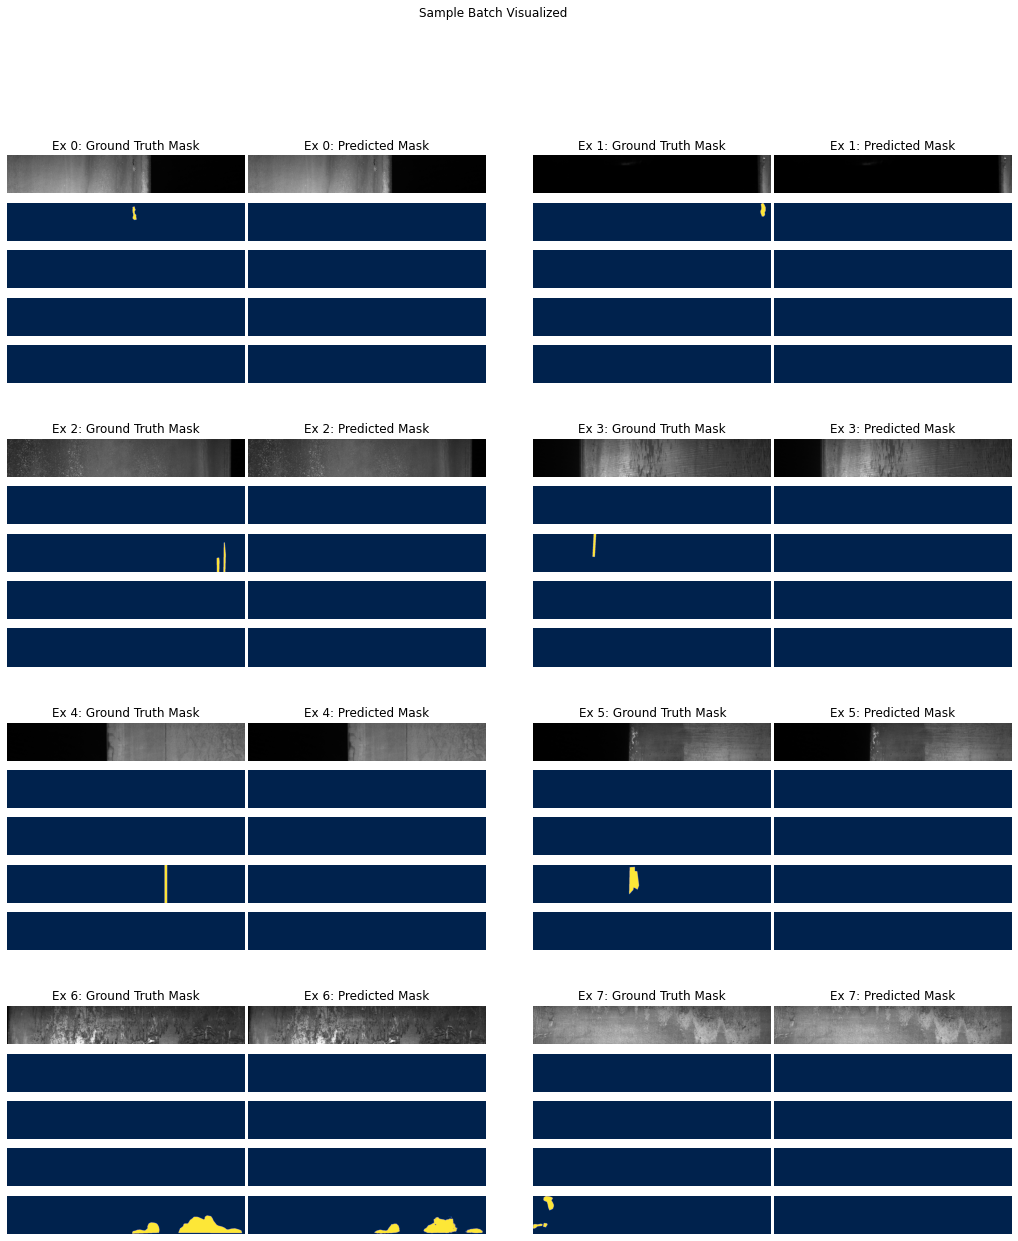

In [15]:
plot_sample_batch(x, y_true, y_pred, softmax_output=False)

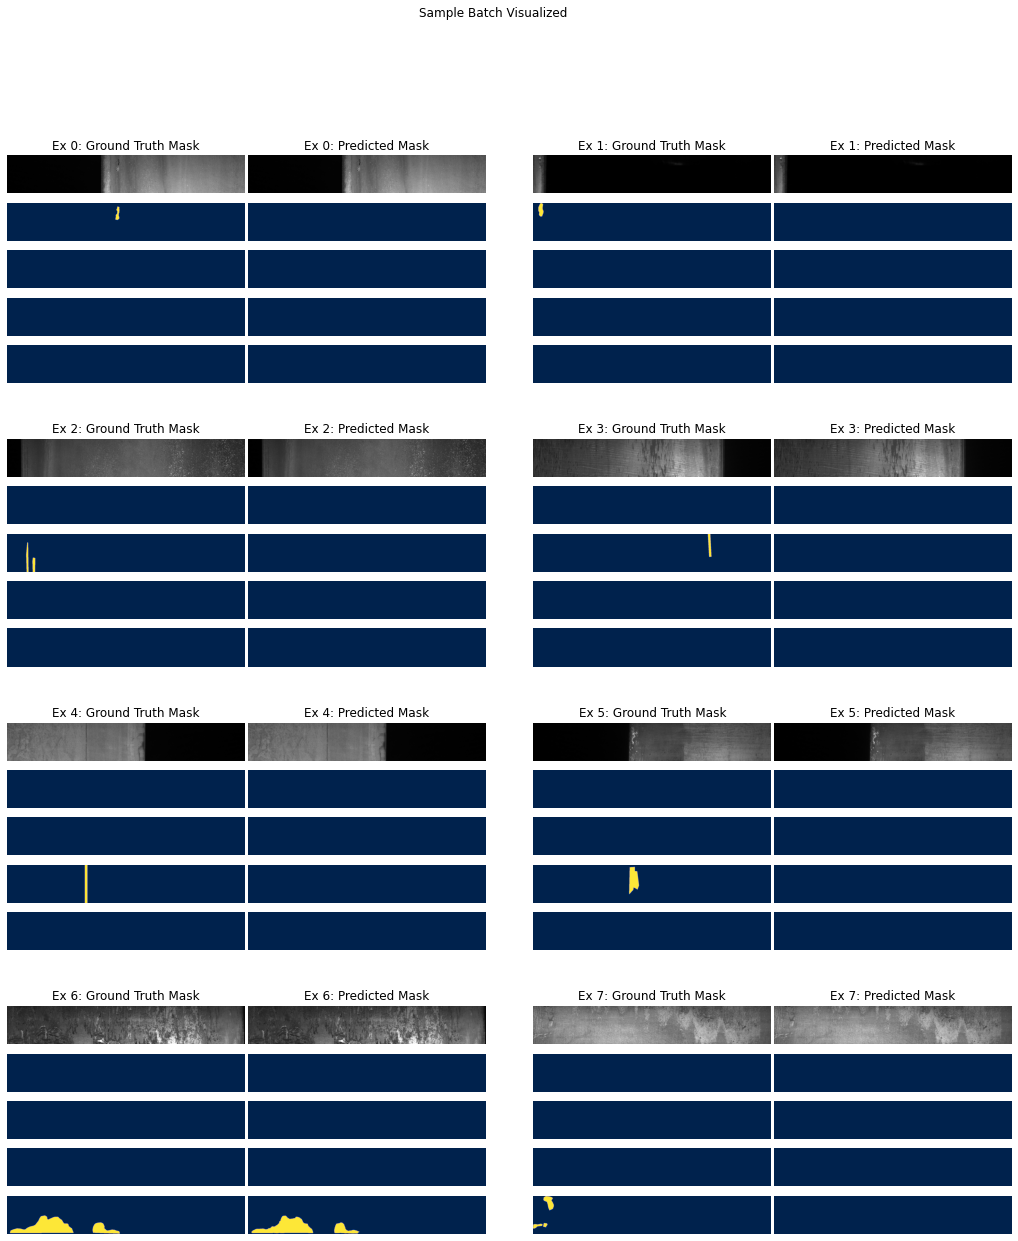

In [16]:
plot_sample_batch(x, y_true, y_pred, softmax_output=False)

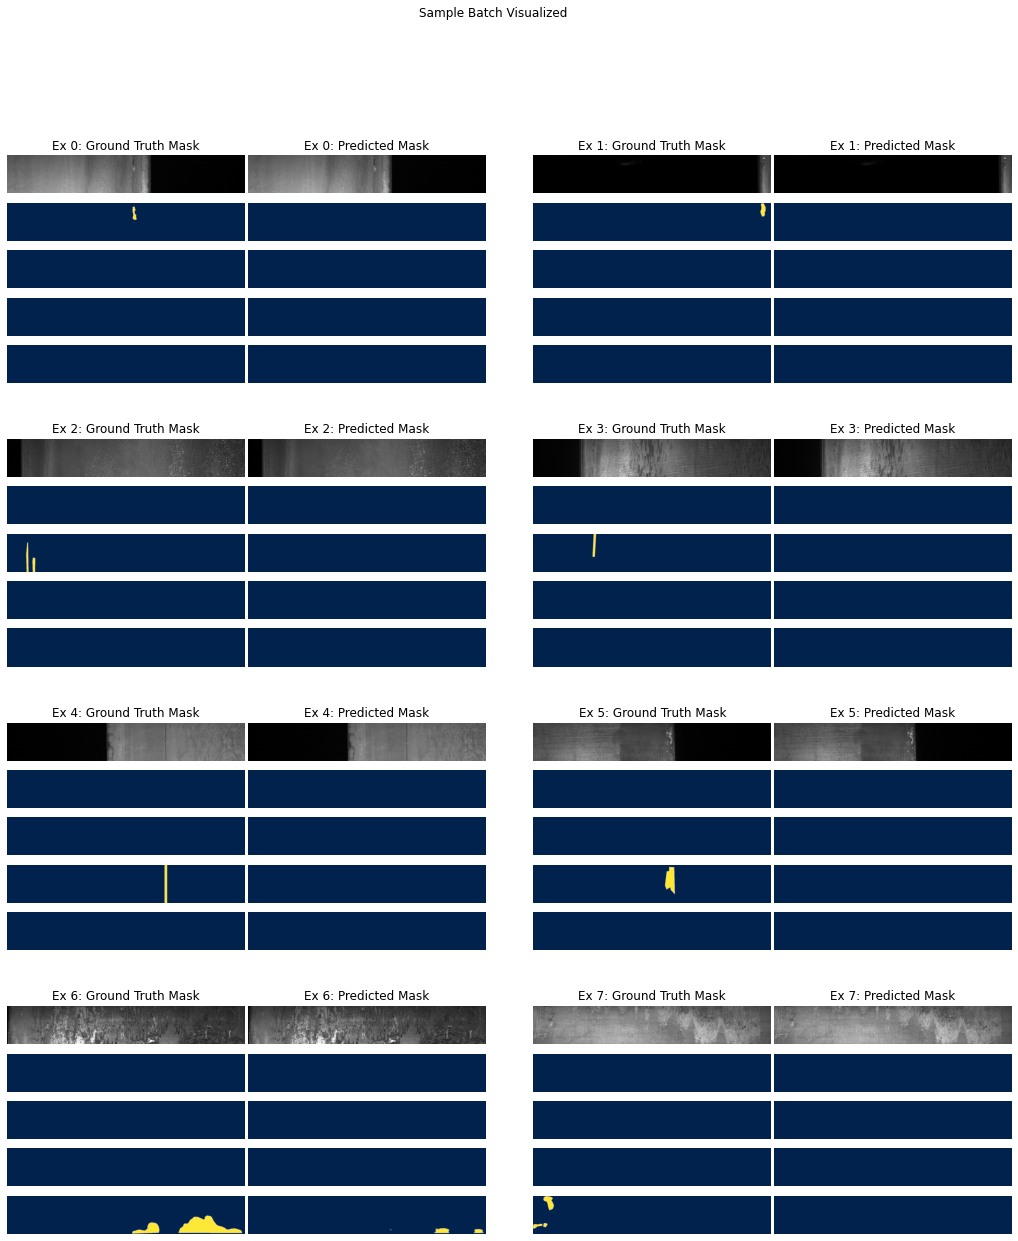

In [36]:
plot_sample_batch(x, y_true, y_pred)

In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from sklearn.utils.class_weight import compute_class_weight


def plot_sample_batch(x, y_true, y_pred):
    """
    Plots a sample batch of data (images and masks) from a
    Tensorflow Dataset.

    Args:
        x - image batch of shape (b, h, w, 3)
        y_true - binary ground truth mask batch of shape (b, h, w, 8)
        y_pred - unet prediction batch of shape (b, h, w, 8)

    """
    fig = plt.figure(figsize=(18, 20))
    fig.suptitle("Sample Batch Visualized")

    x_batch = x
    y_batch = y_true
    # y_pred = create_mask(y_pred)

    batch_size = x_batch.shape[0]
    n_cols = 2
    n_rows = int(batch_size / n_cols)

    outer_grid = gridspec.GridSpec(n_rows, n_cols, wspace=0.1, hspace=0.2)

    for i in range(batch_size):
        inner_grid = gridspec.GridSpecFromSubplotSpec(
            5, 2, subplot_spec=outer_grid[i], wspace=0.01, hspace=0.01
        )

        for j in range(5):
            if j == 0:
                ax = plt.Subplot(fig, inner_grid[j, 0])
                ax.imshow(x_batch[i], vmin=0.0, vmax=1.0)

                ax_true = plt.Subplot(fig, inner_grid[j, 1])
                ax_true.imshow(x_batch[i], vmin=0.0, vmax=1.0)

            else:
                ax = plt.Subplot(fig, inner_grid[j, 0])
                ax.imshow(y_batch[i][..., j - 1], vmin=0.0, vmax=1.0, cmap="cividis")

                ax_true = plt.Subplot(fig, inner_grid[j, 1])
                ax_true.imshow(
                    y_pred[i][..., j - 1], vmin=0.0, vmax=1.0, cmap="cividis"
                )

            if j == 0:
                ax.set_title(f"Ex {i}: Ground Truth Mask")
                ax_true.set_title(f"Ex {i}: Predicted Mask")

            ax.axis("off")
            ax_true.axis("off")

            fig.add_subplot(ax)
            fig.add_subplot(ax_true)

    plt.show()

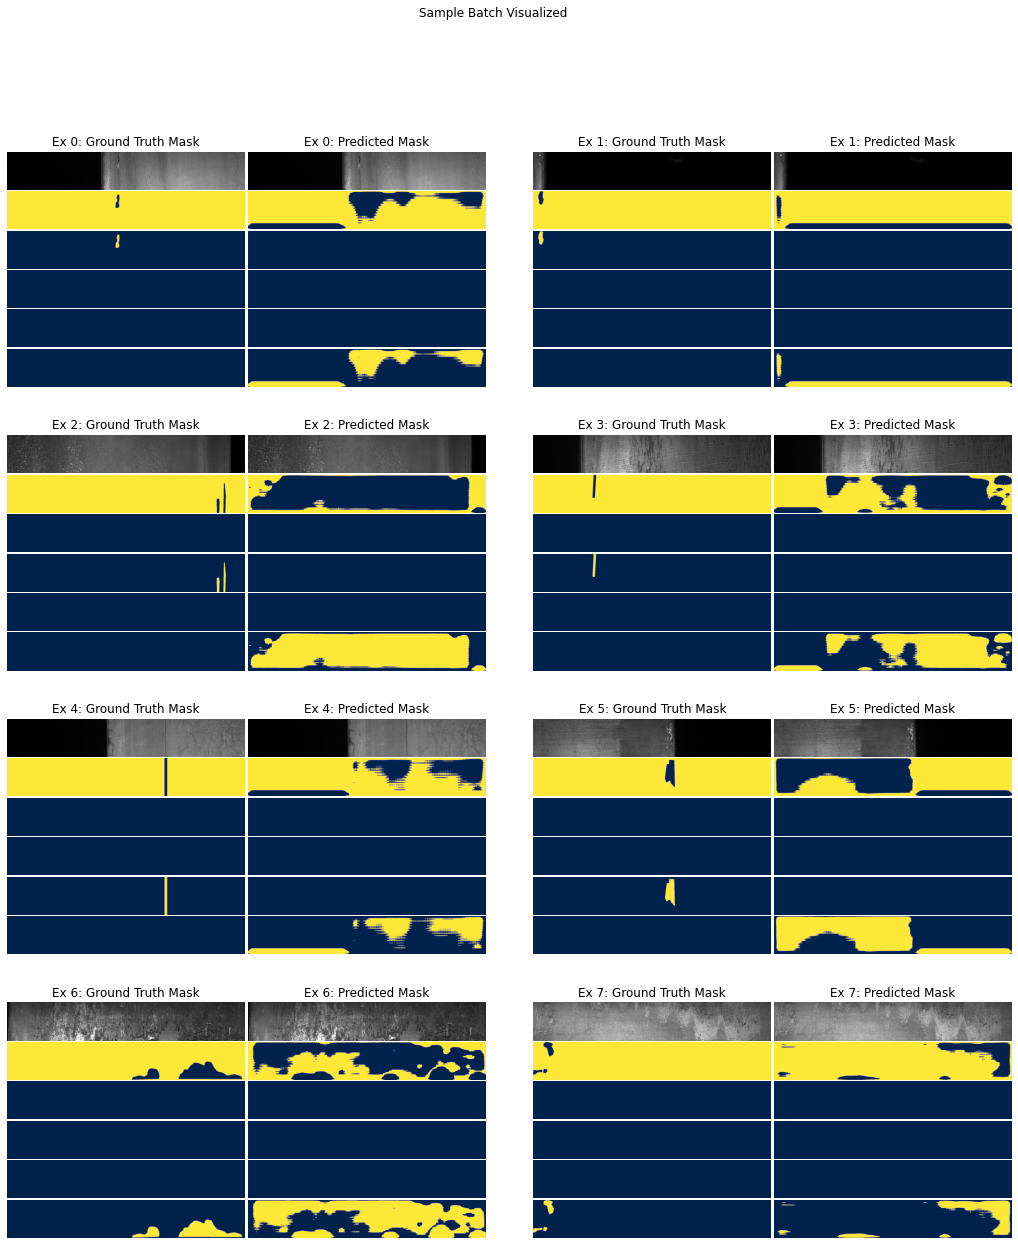

In [15]:
plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

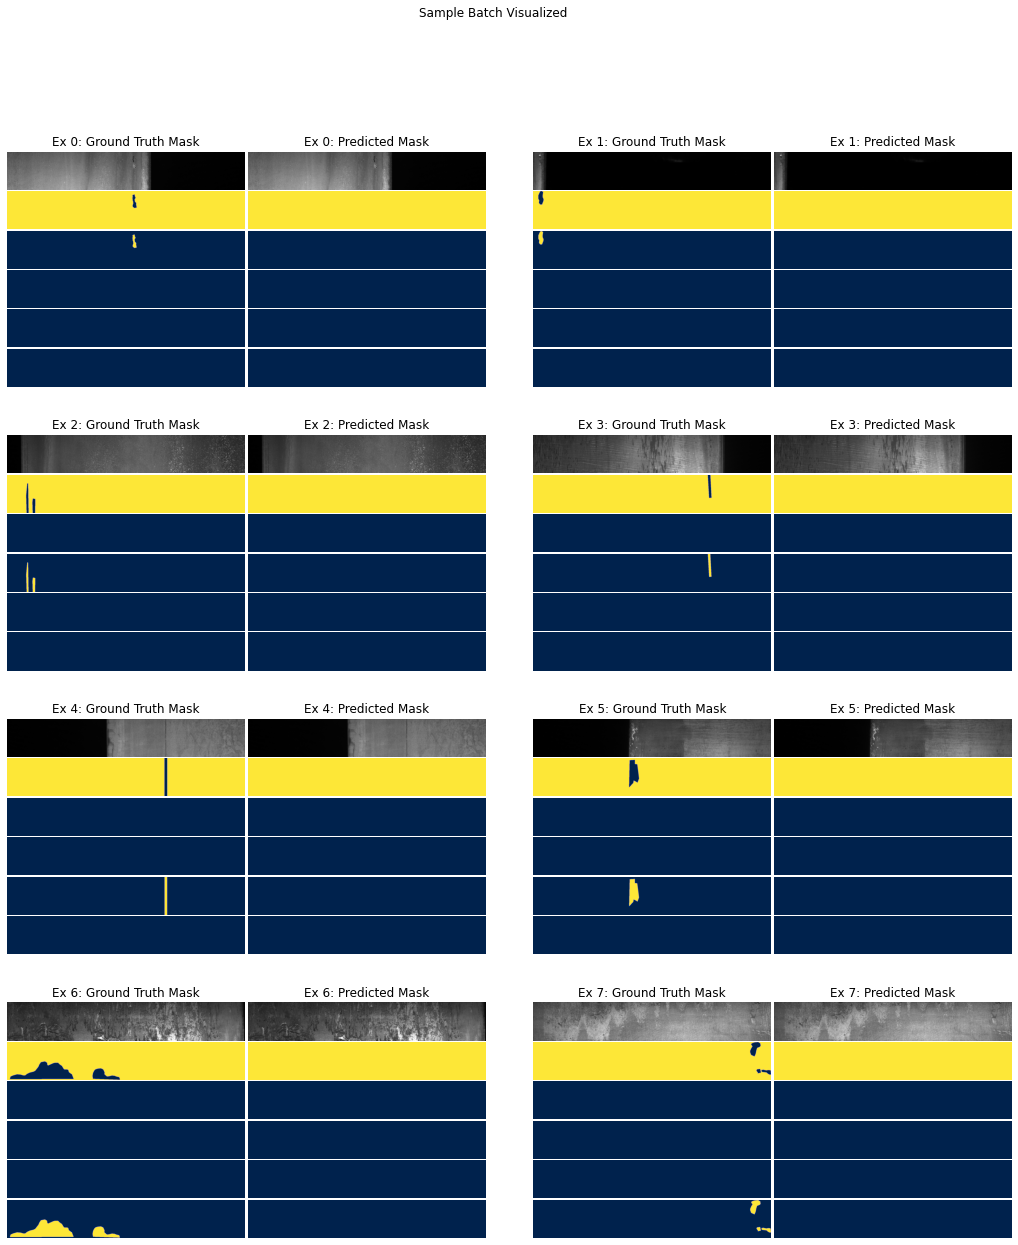

In [14]:
plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

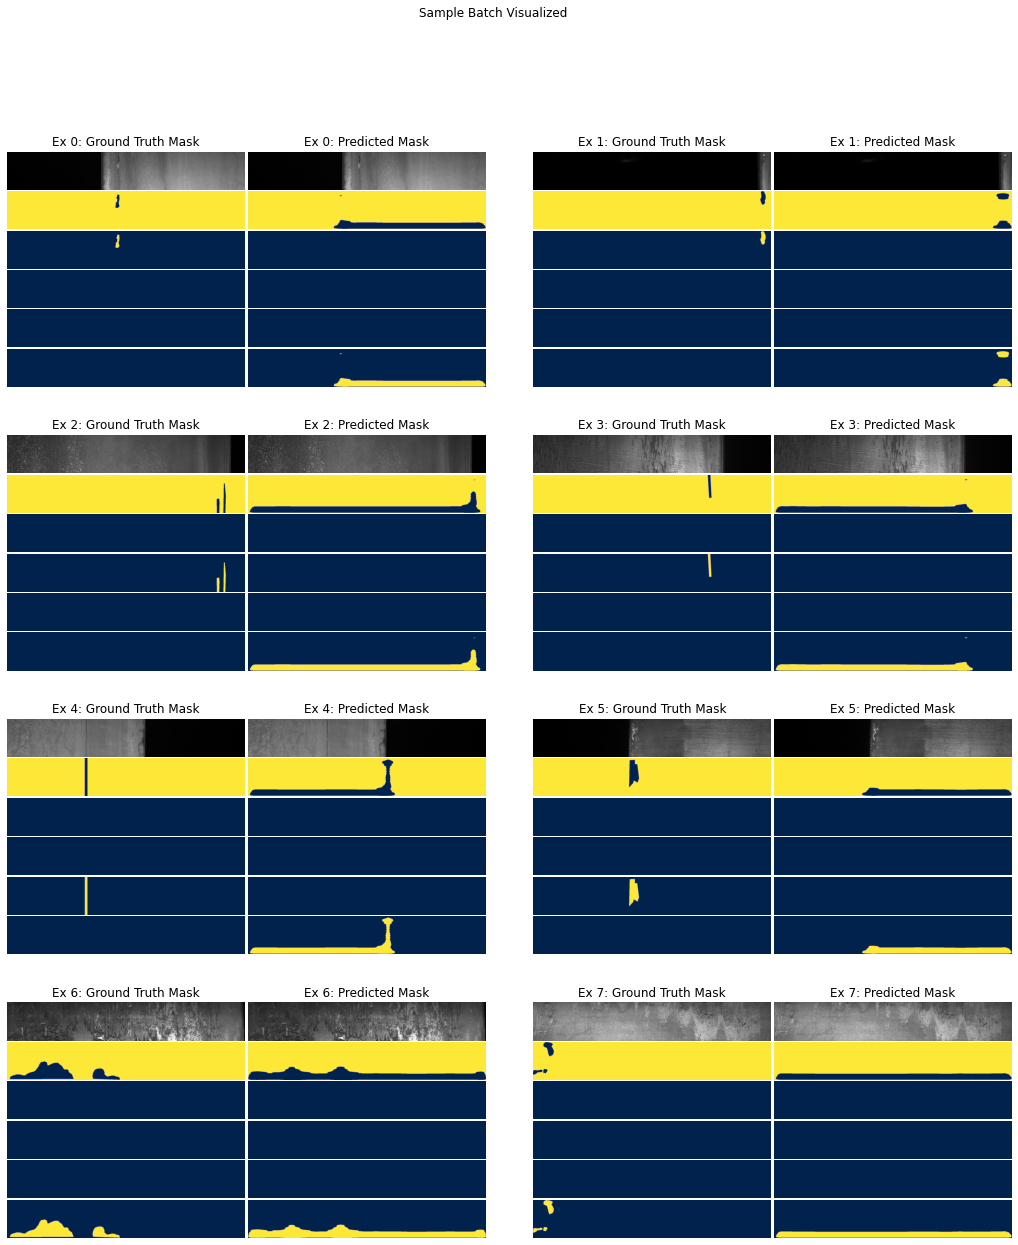

In [40]:
plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

In [13]:
tversky(y_true, y_pred).numpy()

NameError: name 'y_true' is not defined

In [51]:
tversky(y_true, y_pred).numpy()

0.16094021

In [55]:
tversky_axis(y_true, y_pred).numpy()

array([4.9311959e-09, 2.2825477e-09, 6.7360983e-09, 7.2307378e-09,
       2.4138816e-07, 5.0167665e-07, 1.2875189e+00, 2.2827419e-06],
      dtype=float32)

In [67]:
y_true = y_true[:, :, :, 1:]
y_pred = y_pred[:, :, :, 1:]

axes = tuple(range(1, 4))  # compute over H x W x C, preserve batch dimension

true_pos = tf.reduce_sum(y_true * y_pred, axis=axes)
false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=axes)
false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=axes)
alpha = 0.7

In [79]:
smooth = 1e-6
num = true_pos + smooth
den = true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth

In [68]:
true_pos.numpy()[-2]

26230.365

In [69]:
false_neg.numpy()[-2]

7800.635

In [72]:
false_pos.numpy()[-2]

51059.242

In [71]:
26230.365 + (0.7 * 7800.635) + (0.3 * 51059.242) + 1e-6

47008.582101

In [66]:
26230.365 / 409601.617901

0.8562997182417713

In [83]:
num.numpy()[-2] / tf.reduce_sum(den)

<tf.Tensor: shape=(), dtype=float32, numpy=0.16093986>

In [84]:
0.16 * 8

1.28

In [82]:
tf.reduce_sum(den)

<tf.Tensor: shape=(), dtype=float32, numpy=162982.4>

In [74]:
tf.reduce_sum(1 - y_true)

<tf.Tensor: shape=(), dtype=float32, numpy=13044267.0>

In [76]:
tf.reduce_sum((1 - y_true) * y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=370200.66>

In [77]:
256 * 1600 * 4

1638400

In [ ]:
num = true_pos + smooth
den = true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth